# Projection conflict risk

In [1]:
from copro import utils, pipeline, evaluation, plots

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sbs
import os, sys
from sklearn import metrics
import warnings
warnings.simplefilter("ignore")

For better reproducibility, the version numbers of all key packages are provided.

In [2]:
utils.show_versions()

Python version: 3.7.8 | packaged by conda-forge | (default, Jul 31 2020, 01:53:57) [MSC v.1916 64 bit (AMD64)]
copro version: 0.0.6b
geopandas version: 0.8.0
xarray version: 0.15.1
rasterio version: 1.1.0
pandas version: 1.0.3
numpy version: 1.18.1
scikit-learn version: 0.23.2
matplotlib version: 3.2.1
seaborn version: 0.11.0
rasterstats version: 0.14.0


## Setting the scence

In the cfg-file, all the settings for the analysis are defined. By 'parsing' (i.e. reading) it, all settings and file paths are known to the model. This is a simple way to make the code independent of the input data and settings.

In [3]:
settings_file = 'example_settings.cfg'

Based on this cfg-file, the set-up of the run can be initialized. One part of the cfg-file is the specification and creation of an output folder.

In [4]:
config, out_dir = utils.initiate_setup(settings_file)

saving output to folder C:\Users\hoch0001\Documents\_code\copro\example\OUT

no conflict file was specified, hence downloading data from http://ucdp.uu.se/downloads/ged/ged201-csv.zip to C:\Users\hoch0001\Documents\_code\copro\example\example_data\UCDP\ged201-csv.zip



We also need to load in the selected polygons from the very first notebook.

In [5]:
selected_polygons_gdf = gpd.read_file(os.path.join(out_dir, 'selected_polygons.shp'))

Again, for the conversion from numpy array to dataframe this requires a few more steps.

In [6]:
global_arr = np.load(os.path.join(out_dir, 'global_df.npy'), allow_pickle=True)
global_df = pd.DataFrame(data=global_arr, columns=['geometry', 'ID'])
global_df.set_index(global_df.ID, inplace=True)
global_df.drop(['ID'] , axis=1, inplace=True)

## Read data from files

Similar as in the second notebook, we need to collect the variable values for the projection time period. This time, however, we do not need to check whether conflict took place in a polygon as we are now in the projection mode and will not train and test the model again.

In [7]:
X = pipeline.create_X(config, selected_polygons_gdf)

{'poly_ID': Series([], dtype: float64), 'poly_geometry': Series([], dtype: float64), 'total_evaporation': Series([], dtype: float64), 'precipitation': Series([], dtype: float64), 'temperature': Series([], dtype: float64), 'irr_water_demand': Series([], dtype: float64)}

INFO: making a projection
INFO: reading data for period from 2000 to 2015


entering year 2000

listing the geometry of all geographical units
calculating mean total_evaporation per aggregation unit from file C:\Users\hoch0001\Documents\_code\copro\example\example_data\totalEvaporation_monthTot_output_2000_2015_Africa_yearmean.nc for year 2000
calculating mean precipitation per aggregation unit from file C:\Users\hoch0001\Documents\_code\copro\example\example_data\precipitation_monthTot_output_2000-01-31_to_2015-12-31_Africa_yearmean.nc for year 2000
calculating mean temperature per aggregation unit from file C:\Users\hoch0001\Documents\_code\copro\example\example_data\temperature_monthAvg_output_2000-01-31_to_2015-12-3

calculating mean precipitation per aggregation unit from file C:\Users\hoch0001\Documents\_code\copro\example\example_data\precipitation_monthTot_output_2000-01-31_to_2015-12-31_Africa_yearmean.nc for year 2009
calculating mean temperature per aggregation unit from file C:\Users\hoch0001\Documents\_code\copro\example\example_data\temperature_monthAvg_output_2000-01-31_to_2015-12-31_Africa_yearmean.nc for year 2009
calculating mean irr_water_demand per aggregation unit from file C:\Users\hoch0001\Documents\_code\copro\example\example_data\irrWaterDemand.nc for year 2009

entering year 2010

listing the geometry of all geographical units
calculating mean total_evaporation per aggregation unit from file C:\Users\hoch0001\Documents\_code\copro\example\example_data\totalEvaporation_monthTot_output_2000_2015_Africa_yearmean.nc for year 2010
calculating mean precipitation per aggregation unit from file C:\Users\hoch0001\Documents\_code\copro\example\example_data\precipitation_monthTot_output_

## Scaler and classifier

Again, we need to scale this data.

In [9]:
scaler, clf = pipeline.prepare_ML(config)

chosen scaling method is QuantileTransformer()
chosen ML model is RandomForestClassifier(class_weight={1: 100}, n_estimators=1000)


Note, however, that the classifier will have to be loaded from  a pickled-file as we have to use a trained classifier.

## Predict!

With this all in place, we can use the data, the scaler, and the trained classifier to make a prediction whether conflict will take place in a polygon or not. This step still includes multiple predictions per polygon.

In [30]:
y_df = pipeline.run_prediction(X, scaler, clf, config)

INFO: number of data points including missing values: 4384
INFO: number of data points excluding missing values: 4272
INFO: loading the fitted classifier from ../example/OUT\clf.pkl



All the fancy evaluation metrics are not applicable anymore, as we don't have observed data for the future projections. We can still look which fraction of predictions actually predicted conflict for a given polygon.

In [32]:
df_hit, gdf_hit = evaluation.polygon_model_accuracy(y_df, global_df, out_dir=None, make_proj=True)

And this is how it looks like:

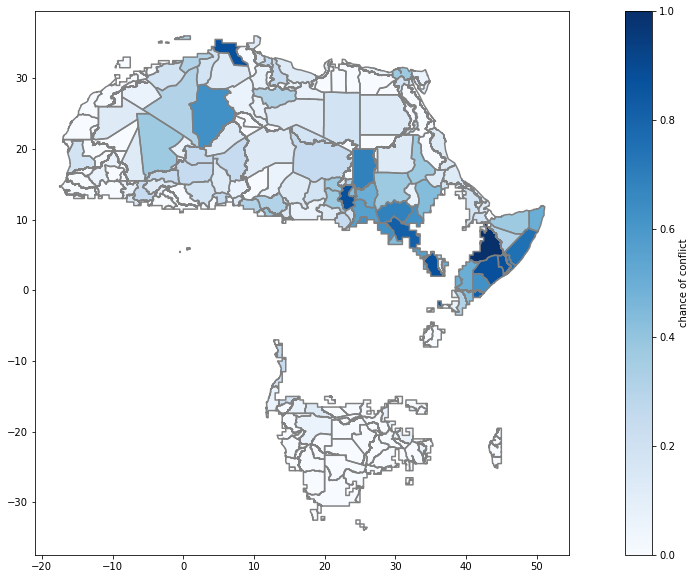

In [35]:
ax = gdf_hit.plot(column='chance_correct_confl_pred', legend=True, figsize=(20, 10), cmap='Blues', vmin=0, vmax=1,
             legend_kwds={'label': "chance of conflict", 'orientation': "vertical"})
selected_polygons_gdf.boundary.plot(ax=ax, color='0.5');

Note that this plot may be different than a similar plot in the previous notebook. This is not unlikely as we use a different amount and different predictions in general here! For instance, we did not repeat the predictions multiple times, nor did we split the data points in test and